In [ ]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
from gymnasium import spaces
import csv
from datetime import datetime

# Set device to CPU for 4GB RAM laptop
# device = torch.device("cpu")
# print(f"Using device: {device}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.load_state_dict(torch.load('checkpoints/best_model/agent_0', map_location=device))

class PPOMemory:
    def __init__(self, batch_size, max_size=2000):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size
        self.max_size = max_size  # Maximum memory size to prevent RAM overflow
    
    def store_memory(self, state, action, prob, val, reward, done):
        # If memory exceeds max size, remove oldest entries (FIFO)
        if len(self.states) >= self.max_size:
            self.states.pop(0)
            self.actions.pop(0)
            self.probs.pop(0)
            self.vals.pop(0)
            self.rewards.pop(0)
            self.dones.pop(0)
            
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(prob)
        self.vals.append(val)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
    
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        # Convert to numpy arrays only when needed (memory efficient)
        states_arr = np.array(self.states)
        actions_arr = np.array(self.actions)
        probs_arr = np.array(self.probs)
        vals_arr = np.array(self.vals)
        rewards_arr = np.array(self.rewards)
        dones_arr = np.array(self.dones)
        
        return states_arr, actions_arr, probs_arr, vals_arr, rewards_arr, dones_arr, batches

class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions, alpha=0.0003):
        super(ActorNetwork, self).__init__()
        
        # Smaller network for faster computation and less memory
        self.actor = nn.Sequential(
            nn.Linear(input_dims, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)
    
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha=0.0003):
        super(CriticNetwork, self).__init__()
        
        # Smaller network for faster computation and less memory
        self.critic = nn.Sequential(
            nn.Linear(input_dims, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)
    
    def forward(self, state):
        value = self.critic(state)
        return value

class Agent:
    def __init__(self, input_dims, n_actions, gamma=0.99, alpha=0.0003, 
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64, 
                 n_epochs=5):  # Reduced from 10 epochs
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        
        self.actor = ActorNetwork(input_dims, n_actions, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size, max_size=2000)  # Limit memory size
    
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
    
    def save_models(self, path):
        os.makedirs(path, exist_ok=True)
        torch.save(self.actor.state_dict(), os.path.join(path, 'actor.pth'))
        torch.save(self.critic.state_dict(), os.path.join(path, 'critic.pth'))
        print(f"Models saved to {path}")
    
    def load_models(self, path):
        try:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            actor_state_dict = torch.load(os.path.join(path, 'actor.pth'), map_location=device)
            critic_state_dict = torch.load(os.path.join(path, 'critic.pth'), map_location=device)
            
            # Get input dimension from saved model
            input_dims = actor_state_dict['actor.0.weight'].shape[1]
            
            # Recreate networks with correct input size
            self.actor = ActorNetwork(input_dims, self.actor.actor[-2].out_features)
            self.critic = CriticNetwork(input_dims)
            
            # Load state dictionaries
            self.actor.load_state_dict(actor_state_dict)
            self.critic.load_state_dict(critic_state_dict)
            print(f"Models loaded from {path}")
        except Exception as e:
            print(f"Error loading models from {path}: {e}")
    
    def choose_action(self, observation):
        # Convert to tensor and process in smaller chunks to save memory
        state = torch.tensor([observation], dtype=torch.float).to(device)
        
        with torch.no_grad():  # No need to track gradients during inference
            dist = self.actor(state)
            value = self.critic(state)
            action = dist.sample()
        
        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()
        
        return action, probs, value
    
    def learn(self):
        memory_size = len(self.memory.states)
        print(f"Starting learning with memory size: {memory_size}")
        
        if memory_size == 0:
            print("Empty memory, nothing to learn from")
            return
            
        # Process smaller batches for large memories
        if memory_size > 2000:
            print(f"Memory too large ({memory_size}), using most recent 2000 entries")
            for attr in ['states', 'actions', 'probs', 'vals', 'rewards', 'dones']:
                setattr(self.memory, attr, getattr(self.memory, attr)[-2000:])
                
        for epoch in range(self.n_epochs):
            print(f"Starting epoch {epoch+1}/{self.n_epochs}")
            
            # Generate batches
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()
            print(f"Generated {len(batches)} batches")
            
            # Compute advantages
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount * (reward_arr[k] + self.gamma * values[k+1] * (1-dones_arr[k]) - values[k])
                    discount *= self.gamma * self.gae_lambda
                advantage[t] = a_t
            
            advantage = torch.tensor(advantage).to(device)
            values = torch.tensor(values).to(device)
            
            # Process batches with progress tracking
            for batch_idx, batch in enumerate(batches):
                if batch_idx % 5 == 0:
                    print(f"  Processing batch {batch_idx+1}/{len(batches)}")
                    
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(device)
                actions = torch.tensor(action_arr[batch]).to(device)
                
                dist = self.actor(states)
                critic_value = self.critic(states)
                critic_value = torch.squeeze(critic_value)
                
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip) * advantage[batch]
                
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
                
                returns = advantage[batch] + values[batch]
                critic_loss = (returns - critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5 * critic_loss
                
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
                # Force garbage collection to free memory
                if batch_idx % 10 == 0:
                    import gc
                    gc.collect()
            
            print(f"Completed epoch {epoch+1}/{self.n_epochs}")
        
        self.memory.clear_memory()
        print("Learning completed and memory cleared")


class DeliveryGridWorld(gym.Env):
    """
    A gridworld environment for multiple delivery bots.
    
    Each agent needs to pick up packages and deliver them to destinations.
    """
    
    def __init__(self, grid_size=10, num_agents=4, num_packages=8, max_steps=5000):
        super(DeliveryGridWorld, self).__init__()
        
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.num_packages = num_packages
        self.max_steps = max_steps
        self.current_step = 0
        self.spark_timers = {i: 0 for i in range(self.num_packages)}
        
        self.current_episode_deliveries = 0
        self.initialized_positions = False

        # Action space: move up, down, left, right, pickup/deliver
        self.action_space = spaces.Discrete(5)
        
        # Observation space
        obs_size = 2 + 1 + (3 * num_packages) + (2 * num_packages) + (2 * num_agents - 2)
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(obs_size,), dtype=np.float32
        )
        
        # Initialize grid and positions
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.reset()

    def _assign_unique_position(self, entity_type, occupied_positions):
        """Assign a unique position to agent, package, or destination with column constraints."""
        while True:
            if entity_type == "package":
                pos = (int(self.np_random.integers(0, self.grid_size-1)), int(self.np_random.integers(0, 1)))  # First two columns
            elif entity_type == "destination":
                pos = (int(self.np_random.integers(0, self.grid_size-1)), int(self.np_random.integers(self.grid_size - 2, self.grid_size-1)))  # Last two columns
            else:  # agent
                pos = (int(self.np_random.integers(0, self.grid_size-1)), int(self.np_random.integers(3, self.grid_size-3)))  # Middle area

            if pos not in occupied_positions:
                occupied_positions.add(pos)
                return pos

    def reset(self, seed=40, options=None):
        """Reset the environment to initial state."""
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)

        self.current_step = 0
        self.current_episode_deliveries = 0

        # Reset grid and agent-related states every episode
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.agent_positions = []
        self.package_status = [0] * self.num_packages
        self.agent_carrying = [None] * self.num_agents

        # Initialize package and destination positions
        self.package_positions = []
        self.destination_positions = []
        occupied_positions = set()

        for _ in range(self.num_packages):
            pos = self._assign_unique_position("package", occupied_positions)
            self.package_positions.append(pos)

        for _ in range(self.num_packages):
            pos = self._assign_unique_position("destination", occupied_positions)
            self.destination_positions.append(pos)

        self.package_destinations_map = {
            i: self.destination_positions[i]
            for i in range(self.num_packages)
        }

        # Assign agents to positions
        occupied_positions = set(self.package_positions + self.destination_positions)
        for _ in range(self.num_agents):
            pos = self._assign_unique_position("agent", occupied_positions)
            self.agent_positions.append(pos)

        # Logging (only for first episode or every 100 episodes)
        if not hasattr(self, '_reset_count'):
            self._reset_count = 0
        self._reset_count += 1
        
        if self._reset_count == 1 or self._reset_count % 100 == 0:
            print("\nEnvironment Reset")
            print(f"Grid Size: {self.grid_size}x{self.grid_size}")
            print(f"Number of Agents: {self.num_agents}")
            print(f"Number of packages: {self.num_packages}")
            print(f"Agent Positions: {self.agent_positions}")
            print(f"Package Positions: {self.package_positions}")
            print(f"Destination Positions: {self.destination_positions}")

        return self._get_observations(), {}
    
    def _get_observations(self):
        """Get observations for all agents."""
        observations = {}
        
        for agent_id in range(self.num_agents):
            obs = self._get_agent_observation(agent_id)
            observations[agent_id] = obs
            
        return observations
    
    def _get_agent_observation(self, agent_id):
        """Get observation for a specific agent."""
        agent_pos = self.agent_positions[agent_id]
        
        # Agent's own position
        obs = [agent_pos[0] / (self.grid_size - 1), agent_pos[1] / (self.grid_size - 1)]
        
        # Carrying status
        carrying = 0 if self.agent_carrying[agent_id] is None else self.agent_carrying[agent_id] + 1
        obs.append(carrying / (self.num_packages + 1))
        
        # Package positions and status
        for i in range(self.num_packages):
            if self.package_status[i] == 2:  # Delivered
                obs.extend([-1.0, -1.0, 1.0])
            else:
                package_pos = self.package_positions[i]
                obs.extend([
                    package_pos[0] / (self.grid_size - 1),
                    package_pos[1] / (self.grid_size - 1),
                    self.package_status[i] / 2.0  # Normalize status
                ])
        
        # Destination positions
        for dest_pos in self.destination_positions:
            obs.extend([dest_pos[0] / (self.grid_size - 1), dest_pos[1] / (self.grid_size - 1)])
        
        # Other agents' positions
        for i in range(self.num_agents):
            if i != agent_id:
                other_pos = self.agent_positions[i]
                obs.extend([other_pos[0] / (self.grid_size - 1), other_pos[1] / (self.grid_size - 1)])
        
        return np.array(obs, dtype=np.float32)



def step(self, actions):
    """Execute actions for all agents."""
    self.current_step += 1
    
    # Initialize tracking dictionaries
    rewards = {agent_id: 0.0 for agent_id in range(self.num_agents)}
    infos = {agent_id: {} for agent_id in range(self.num_agents)}
    
    # Initialize tracking systems if not present
    if not hasattr(self, 'previous_positions'):
        self.previous_positions = list(self.agent_positions)
    if not hasattr(self, 'agent_momentum'):
        self.agent_momentum = {agent_id: {'vector': [0.0, 0.0], 'consistency': 0} 
                            for agent_id in range(self.num_agents)}
    if not hasattr(self, 'previous_distances'):
        self.previous_distances = {}
    
    # Add counters for deliveries and collisions
    deliveries_this_step = 0
    collisions_this_step = 0

    # Print status every 100 steps to reduce output volume
    if self.current_step % 100 == 0:
        print(f"\n--- Step {self.current_step} ---")
        print(f"Agent Positions: {self.agent_positions}")
        for i in range(self.num_agents):
            carrying = "None" if self.agent_carrying[i] is None else f"Package {self.agent_carrying[i]}"
            print(f"Agent {i} at {self.agent_positions[i]} carrying: {carrying}")
    
    # Store previous positions for momentum calculations
    self.previous_positions = list(self.agent_positions)
    new_positions = []

    # Process movement actions
    for agent_id, action in actions.items():
        current_pos = self.agent_positions[agent_id]
        new_pos = list(current_pos)

        if action == 0:  # Up
            new_pos[1] = max(0, current_pos[1] - 1)
        elif action == 1:  # Down
            new_pos[1] = min(self.grid_size - 1, current_pos[1] + 1)
        elif action == 2:  # Left
            new_pos[0] = max(0, current_pos[0] - 1)
        elif action == 3:  # Right
            new_pos[0] = min(self.grid_size - 1, current_pos[0] + 1)

        new_positions.append(tuple(new_pos))
    
    # Check for collisions
    for agent_id, new_pos in enumerate(new_positions):
        collision = False
        for other_id, other_new_pos in enumerate(new_positions):
            if agent_id != other_id and new_pos == other_new_pos:
                collision = True
                break

        # Update position if no collision
        if not collision and new_pos not in self.agent_positions[:agent_id] + self.agent_positions[agent_id+1:]:
            self.agent_positions[agent_id] = new_pos
        else:
            rewards[agent_id] -= 0.1  # Penalty for collision
            collisions_this_step += 1
    
    # Calculate momentum-based rewards after movement
    for agent_id in range(self.num_agents):
        # Calculate movement vector
        prev_pos = self.previous_positions[agent_id]
        curr_pos = self.agent_positions[agent_id]
        move_vector = [curr_pos[0] - prev_pos[0], curr_pos[1] - prev_pos[1]]
        
        # Skip momentum calculation if no movement
        if move_vector == [0, 0]:
            continue
            
        # Calculate target position based on agent's status
        if self.agent_carrying[agent_id] is None:
            # Find closest undelivered package
            closest_dist = float('inf')
            target_pos = None
            
            for pkg_idx, pkg_pos in enumerate(self.package_positions):
                if self.package_status[pkg_idx] == 0:  # Package is available
                    dist = abs(curr_pos[0] - pkg_pos[0]) + abs(curr_pos[1] - pkg_pos[1])  # Manhattan distance
                    if dist < closest_dist:
                        closest_dist = dist
                        target_pos = pkg_pos
        else:
            # Target is the destination for the package being carried
            pkg_idx = self.agent_carrying[agent_id]
            target_pos = self.package_destinations_map[pkg_idx]
        
        # If we have a target, calculate alignment and momentum rewards
        if target_pos:
            # Direction vector toward target
            target_vector = [target_pos[0] - curr_pos[0], target_pos[1] - curr_pos[1]]
            target_dist = abs(target_vector[0]) + abs(target_vector[1])  # Manhattan distance
            
            if target_dist > 0:
                # Normalize target vector (using Manhattan distance for simplicity)
                norm_target = [target_vector[0]/target_dist if target_dist > 0 else 0, 
                            target_vector[1]/target_dist if target_dist > 0 else 0]
                
                # Calculate dot product to measure alignment (-1 to 1)
                # For Manhattan movement, this simplifies to checking if we moved in the right direction
                alignment = 0
                if move_vector[0] != 0 and target_vector[0] != 0:
                    alignment += 1 if (move_vector[0] * target_vector[0]) > 0 else -1
                if move_vector[1] != 0 and target_vector[1] != 0:
                    alignment += 1 if (move_vector[1] * target_vector[1]) > 0 else -1
                
                # Update momentum vector with decay
                momentum_decay = 0.7
                self.agent_momentum[agent_id]['vector'] = [
                    momentum_decay * self.agent_momentum[agent_id]['vector'][0] + move_vector[0],
                    momentum_decay * self.agent_momentum[agent_id]['vector'][1] + move_vector[1]
                ]
                
                # Calculate momentum magnitude (Manhattan)
                momentum_mag = abs(self.agent_momentum[agent_id]['vector'][0]) + abs(self.agent_momentum[agent_id]['vector'][1])
                
                # Update consistency counter
                if alignment > 0:
                    self.agent_momentum[agent_id]['consistency'] += 1
                else:
                    self.agent_momentum[agent_id]['consistency'] = max(0, self.agent_momentum[agent_id]['consistency'] - 2)
                
                # Calculate momentum reward based on alignment, consistency, and magnitude
                consistency_factor = min(5, self.agent_momentum[agent_id]['consistency']) * 0.05
                alignment_reward = alignment * 0.05
                magnitude_factor = min(1.0, momentum_mag / 5.0) * 0.03  # Scale momentum magnitude
                
                # Only apply magnitude factor when alignment is positive
                momentum_reward = alignment_reward + consistency_factor
                if alignment > 0:
                    momentum_reward += magnitude_factor
                
                # Apply momentum reward
                rewards[agent_id] += momentum_reward
                
                # Add directional incentive based on distance to target
                # More reward for moving toward target when further away
                distance_factor = min(1.0, target_dist / 10.0) * 0.1
                if alignment > 0:
                    rewards[agent_id] += distance_factor
                    
            # Store current distance for progress tracking in the next step
            self.previous_distances[agent_id] = target_dist
    
    # Process pickup/deliver actions
    for agent_id, action in actions.items():
        if action == 4:  # Pickup or deliver
            current_pos = self.agent_positions[agent_id]

            if self.agent_carrying[agent_id] is None:
                # Try to pick up a package
                for pkg_idx, pkg_pos in enumerate(self.package_positions):
                    if current_pos == pkg_pos and self.package_status[pkg_idx] == 0:
                        self.agent_carrying[agent_id] = pkg_idx
                        self.package_status[pkg_idx] = 1
                        rewards[agent_id] += 2.0
                        # Reset momentum after pickup - new goal
                        self.agent_momentum[agent_id]['vector'] = [0.0, 0.0]
                        self.agent_momentum[agent_id]['consistency'] = 0
                        print(f"Agent {agent_id} picked up package {pkg_idx} at {current_pos}")
                        break
            else:
                # Try to deliver a package
                pkg_idx = self.agent_carrying[agent_id]
                dest_pos = self.package_destinations_map[pkg_idx]  # Get the correct destination
                
                if current_pos == dest_pos:
                    self.package_status[pkg_idx] = 2  # Mark as delivered
                    self.agent_carrying[agent_id] = None
                    rewards[agent_id] += 10.0
                    # Reset momentum after delivery - new goal
                    self.agent_momentum[agent_id]['vector'] = [0.0, 0.0]
                    self.agent_momentum[agent_id]['consistency'] = 0
                    deliveries_this_step += 1  # Increment delivery counter
                    self.current_episode_deliveries += 1  # Total episode deliveries
                    print(f"🎉 SUCCESS! Agent {agent_id} delivered package {pkg_idx} to destination at {current_pos}")

    # Progress rewards - if agent got closer to its target
    for agent_id in range(self.num_agents):
        current_pos = self.agent_positions[agent_id]
        
        # Calculate current distance to target
        if self.agent_carrying[agent_id] is None:
            # Find closest available package
            closest_dist = float('inf')
            for pkg_idx, pkg_pos in enumerate(self.package_positions):
                if self.package_status[pkg_idx] == 0:  # Available package
                    dist = abs(current_pos[0] - pkg_pos[0]) + abs(current_pos[1] - pkg_pos[1])
                    if dist < closest_dist:
                        closest_dist = dist
        else:
            # Distance to destination
            pkg_idx = self.agent_carrying[agent_id]
            dest_pos = self.package_destinations_map[pkg_idx]
            closest_dist = abs(current_pos[0] - dest_pos[0]) + abs(current_pos[1] - dest_pos[1])
        
        # Reward progress toward target if we have previous distance data
        if agent_id in self.previous_distances and closest_dist < self.previous_distances.get(agent_id, float('inf')):
            rewards[agent_id] += 0.1  # Small reward for getting closer to target

    # Smaller negative reward each step to encourage efficiency
    for agent_id in range(self.num_agents):
        rewards[agent_id] -= 0.005  # Small penalty for each step

    # Check if episode is done
    delivered_count = sum(1 for status in self.package_status if status == 2)
    done = (delivered_count == self.num_packages)
    
    # Add completion bonus
    if done and self.current_step < self.max_steps:
        completion_bonus = 25.0
        for agent_id in range(self.num_agents):
            rewards[agent_id] += completion_bonus
            print(f"Agent {agent_id} received completion bonus: +{completion_bonus}")

    # Print status periodically
    if self.current_step % 100 == 0:
        print(f"Packages delivered: {delivered_count}/{self.num_packages}")

    # End episode if max steps reached
    if self.current_step >= self.max_steps:
        print(f"\nMax steps ({self.max_steps}) reached!")
        done = True
    
    truncated = {agent_id: False for agent_id in range(self.num_agents)}
    dones = {agent_id: done for agent_id in range(self.num_agents)}
    dones["__all__"] = done

    # Include metrics in info
    infos["__all__"] = {
        "deliveries": deliveries_this_step,
        "collisions": collisions_this_step,
        "total_delivered": delivered_count
    }

    return self._get_observations(), rewards, dones, truncated, infos


def train_agents(env, agents, n_episodes=1000, save_interval=100,
                 checkpoint_dir='checkpoints', log_dir='logs', max_steps_per_episode=3000):
    """Train multiple agents using PPO in a delivery environment."""
    import os
    import gc  # For garbage collection
    from datetime import datetime
    import csv
    
    # Create directories for checkpoints and logs
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # Setup logging
    log_file = os.path.join(log_dir, 'training_log.csv')
    write_header = not os.path.exists(log_file)

    best_reward = -np.inf
    score_history = []

    for episode in range(n_episodes+1):
        print(f"\n==== Starting Episode {episode} ====")
        obs, _ = env.reset()
        done = False
        score = 0
        steps = 0
        deliveries = 0
        collisions = 0

        try:
            # Run until episode is done or max steps reached
            while not done and steps < max_steps_per_episode:
                # Collect actions from agents
                actions = {}
                for agent_id, agent in enumerate(agents):
                    observation = obs[agent_id]
                    action, prob, val = agent.choose_action(observation)
                    actions[agent_id] = action

                # Execute step in environment
                try:
                    next_obs, rewards, dones, truncated, infos = env.step(actions)
                    info = infos.get("__all__", {})
                    
                    # Track metrics
                    deliveries += info.get("deliveries", 0)
                    collisions += info.get("collisions", 0)
                    
                    # Store experiences for each agent
                    for agent_id, agent in enumerate(agents):
                        agent.remember(obs[agent_id], actions[agent_id], prob, val, rewards[agent_id], dones[agent_id])
                        score += rewards[agent_id]
                    
                    obs = next_obs
                    done = dones["__all__"]
                    steps += 1
                    
                except Exception as e:
                    print(f"Error during environment step: {e}")
                    done = True  # Force episode end if there's an error
            
            # Force end if max steps reached
            if steps >= max_steps_per_episode and not done:
                print(f"Episode {episode} force-terminated after {max_steps_per_episode} steps")
            else:
                print(f"Episode {episode} completed after {steps} steps with {deliveries} deliveries")
                    
            # Learning phase - process each agent separately to conserve memory
            for agent_id, agent in enumerate(agents):
                print(f"Training agent {agent_id}...")
                try:
                    agent.learn()
                    # Force garbage collection after each agent learns
                    gc.collect()
                except Exception as e:
                    print(f"Error during agent {agent_id} learning: {e}")
                
            # Logging
            score_history.append(score)
            avg_score = np.mean(score_history[-100:]) if len(score_history) >= 100 else np.mean(score_history)
            
            # Save to log file
            try:
                with open(log_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    if write_header:
                        writer.writerow(["episode", "reward", "avg_reward", "steps", "deliveries", "collisions", "timestamp"])
                        write_header = False
                    writer.writerow([episode, score, avg_score, steps, deliveries, collisions, datetime.now().isoformat()])
            except Exception as e:
                print(f"Error writing to log file: {e}")
                
            # Print progress update
            if episode % 10 == 0:
                print(f'Episode: {episode}, Score: {score:.1f}, Avg Score: {avg_score:.1f}, Steps: {steps}, Deliveries: {deliveries}, Collisions: {collisions}')
            
            # Save best model
            if avg_score > best_reward and episode > 50:
                best_reward = avg_score
                try:
                    best_dir = os.path.join(checkpoint_dir, 'best')
                    os.makedirs(best_dir, exist_ok=True)
                    for agent_id, agent in enumerate(agents):
                        agent.save_models(os.path.join(best_dir, f'agent_{agent_id}'))
                    print(f"Best model saved with avg_score: {avg_score:.2f}")
                except Exception as e:
                    print(f"Error saving best model: {e}")
                
            # Regular checkpoint saving
            if episode % save_interval == 0 and episode > 0:
                try:
                    checkpoint_episode_dir = os.path.join(checkpoint_dir, f'checkpoint_{episode}')
                    os.makedirs(checkpoint_episode_dir, exist_ok=True)
                    for agent_id, agent in enumerate(agents):
                        agent.save_models(os.path.join(checkpoint_episode_dir, f'agent_{agent_id}'))
                    print(f"Checkpoint saved at episode {episode}")
                except Exception as e:
                    print(f"Error saving checkpoint: {e}")
            # Force garbage collection between episodes
            gc.collect()
                
        except Exception as e:
            print(f"Error during episode {episode}: {e}")
            import traceback
            traceback.print_exc()
            continue  # Move to next episode if there's an error




## Training the agents

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train multi-agent delivery bots')
    parser.add_argument('--grid_size', type=int, default=10, help='Size of the grid world')
    parser.add_argument('--num_agents', type=int, default=4, help='Number of agents')
    parser.add_argument('--num_packages', type=int, default=8, help='Number of packages')
    parser.add_argument('--episodes', type=int, default=400, help='Number of training episodes')
    parser.add_argument('--save_interval', type=int, default=100, help='Episodes between checkpoints')
    parser.add_argument('--max_steps', type=int, default=3000, help='Maximum steps per episode')
    args, unknown = parser.parse_known_args()
    
    print("Starting training with settings:")
    print(f"- Grid size: {args.grid_size}x{args.grid_size}")
    print(f"- Agents: {args.num_agents}")
    print(f"- Packages: {args.num_packages}")
    print(f"- Episodes: {args.episodes}")
    print(f"- Max steps per episode: {args.max_steps}")

    # Create environment
    env = DeliveryGridWorld(
        grid_size=args.grid_size,
        num_agents=args.num_agents,
        num_packages=args.num_packages,
        max_steps=5000  # Hard limit for environment steps
    )
    
    # Get observation dimension from environment
    temp_obs, _ = env.reset()
    obs_dim = temp_obs[0].shape[0]
    print(f"Observation dimension: {obs_dim}")
    
    # Create agents with memory-optimized settings
    agents = []
    for _ in range(args.num_agents):
        agent = Agent(
            input_dims=obs_dim,
            n_actions=env.action_space.n,
            batch_size=32,  # Smaller batch size for less memory usage
            alpha=0.0003,
            gamma=0.99,
            n_epochs=3  # Fewer epochs for faster learning
        )
        agents.append(agent)

    # Set up paths for saving models and logs
    model_save_path = "checkpoints"
    log_save_path = "logs"

    # Train agents
    train_agents(
        env=env,
        agents=agents,
        n_episodes=args.episodes,
        save_interval=args.save_interval,
        checkpoint_dir=model_save_path,
        log_dir=log_save_path,
        max_steps_per_episode=args.max_steps
    )
    
    print("Training completed!")

###  While trainnig agents on laptop VS Code crashed during training. Checkpoint was set to 100 episodes but it crashed at almost 30 episodes. In colab due to constraints could only train till episode 50 using T4 gpu

## Plotting logs

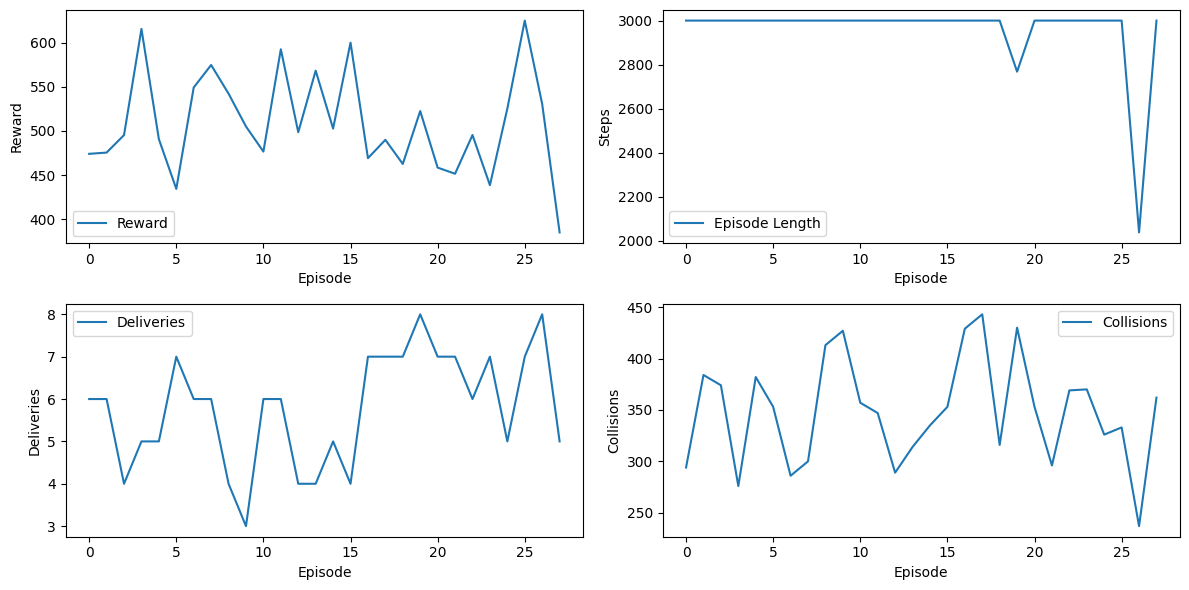

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

log_df = pd.read_csv('logs/training_log.csv')

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(log_df['episode'], log_df['reward'], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(log_df['episode'], log_df['steps'], label='Episode Length')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(log_df['episode'], log_df['deliveries'], label='Deliveries')
plt.xlabel('Episode')
plt.ylabel('Deliveries')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(log_df['episode'], log_df['collisions'], label='Collisions')
plt.xlabel('Episode')
plt.ylabel('Collisions')
plt.legend()

plt.tight_layout()
plt.show()


## Visualizing using sumo

In [ ]:
import os
import argparse
import numpy as np
import torch
import traci
import traci.constants as tc
import subprocess
import tempfile
import time
# from delivery_environment import DeliveryGridWorld

def generate_sumo_config(grid_size, temp_dir):
    """Generate SUMO configuration files for visualization."""
    
    # Scale factor to make the grid visualization better in SUMO
    scale = 1 # enlarges 10 times
    
    # Create nodes file
    nodes_file = os.path.join(temp_dir, "delivery_grid.nod.xml")
    with open(nodes_file, "w") as f:
        f.write('<nodes>\n')
        # Create nodes for each intersection in the grid
        for y in range(grid_size + 1):
            for x in range(grid_size + 1):
                f.write(f'    <node id="n{x}_{y}" x="{x * scale}" y="{y * scale}" type="priority"/>\n')
        f.write('</nodes>\n')
    
    # Create edges file
    edges_file = os.path.join(temp_dir, "delivery_grid.edg.xml")
    with open(edges_file, "w") as f:
        f.write('<edges>\n')
        # Create horizontal edges
        for y in range(grid_size + 1):
            for x in range(grid_size):
                f.write(f'    <edge id="h{x}_{y}" from="n{x}_{y}" to="n{x+1}_{y}" numLanes="1" speed="13.89"/>\n')
                f.write(f'    <edge id="h{x}_{y}_back" from="n{x+1}_{y}" to="n{x}_{y}" numLanes="1" speed="13.89"/>\n')
        
        # Create vertical edges
        for x in range(grid_size + 1):
            for y in range(grid_size):
                f.write(f'    <edge id="v{x}_{y}" from="n{x}_{y}" to="n{x}_{y+1}" numLanes="1" speed="13.89"/>\n')
                f.write(f'    <edge id="v{x}_{y}_back" from="n{x}_{y+1}" to="n{x}_{y}" numLanes="1" speed="13.89"/>\n')
        f.write('</edges>\n')
    
    # Create netconvert command
    netconvert_cmd = [
        "netconvert",
        "--node-files", nodes_file,
        "--edge-files", edges_file,
        "--output-file", os.path.join(temp_dir, "delivery_grid.net.xml"),
        "--no-turnarounds", "true"
    ]
    
    # Run netconvert
    subprocess.run(netconvert_cmd)
    
    # Create routes file
    routes_file = os.path.join(temp_dir, "delivery_grid.rou.xml")
    with open(routes_file, "w") as f:
        f.write('<routes>\n')
        # Define vehicle types - Fix: Use valid SUMO shapes
        f.write('    <vType id="agent" length="2" minGap="1" maxSpeed="5" guiShape="passenger" color="0,0,255"/>\n')
        f.write('    <vType id="package" length="1" minGap="1" maxSpeed="0.1" guiShape="delivery" color="255,0,0"/>\n')
        f.write('    <vType id="destination" length="1" minGap="1" maxSpeed="0.1" guiShape="truck" color="0,255,0"/>\n')
        
        # Create a route that covers the entire grid
        f.write('    <route id="grid_route" edges="')
        for y in range(grid_size + 1):
            for x in range(grid_size):
                f.write(f"h{x}_{y} ")
            if y < grid_size:
                f.write(f"v{grid_size}_{y} ")
                for x in range(grid_size-1, -1, -1):
                    f.write(f"h{x}_{y+1}_back ")
                if y < grid_size-1:
                    f.write(f"v0_{y+1}_back ")
        f.write('"/>\n')
        f.write('</routes>\n')
    
    # Create SUMO configuration file
    sumo_config = os.path.join(temp_dir, "delivery_grid.sumocfg")
    with open(sumo_config, "w") as f:
        f.write('<configuration>\n')
        f.write('    <input>\n')
        f.write(f'        <net-file value="delivery_grid.net.xml"/>\n')
        f.write(f'        <route-files value="delivery_grid.rou.xml"/>\n')
        f.write('    </input>\n')
        f.write('    <time>\n')
        f.write('        <begin value="0"/>\n')
        f.write('        <end value="1000"/>\n')
        f.write('    </time>\n')
        f.write('</configuration>\n')
    
    return sumo_config

def get_nearest_edge(x, y, grid_size, scale=100):
    """Get the nearest edge ID for a given position."""
    # Find nearest node coordinates
    node_x = round(x / scale) * scale
    node_y = round(y / scale) * scale
    
    # Convert to node indices
    nx = int(node_x / scale)
    ny = int(node_y / scale)
    
    # Ensure we're within bounds
    nx = max(0, min(nx, grid_size))
    ny = max(0, min(ny, grid_size))
    
    # Determine which edge to use based on proximity to the nearest node
    if abs(x - node_x) > abs(y - node_y):
        # Closer to horizontal edge
        if x > node_x and nx < grid_size:
            return f"h{nx}_{ny}"
        elif nx > 0:
            return f"h{nx-1}_{ny}_back"
    else:
        # Closer to vertical edge
        if y > node_y and ny < grid_size:
            return f"v{nx}_{ny}"
        elif ny > 0:
            return f"v{nx}_{ny-1}_back"
    
    # Fallback to a default edge
    if grid_size > 0:
        return f"h0_0"
    return ""

def generate_sumo_config(grid_size, temp_dir):
    """Generate SUMO configuration files for visualization."""
    
    # Scale factor to make the grid visualization better in SUMO
    scale = 100
    
    # Create nodes file
    nodes_file = os.path.join(temp_dir, "delivery_grid.nod.xml")
    with open(nodes_file, "w") as f:
        f.write('<nodes>\n')
        # Create nodes for each intersection in the grid
        for y in range(grid_size + 1):
            for x in range(grid_size + 1):
                # Make nodes visible
                f.write(f'    <node id="n{x}_{y}" x="{x * scale}" y="{y * scale}" type="priority"/>\n')
        f.write('</nodes>\n')
    
    # Create edges file
    edges_file = os.path.join(temp_dir, "delivery_grid.edg.xml")
    with open(edges_file, "w") as f:
        f.write('<edges>\n')
        # Create horizontal edges - just make a simple grid
        for y in range(grid_size + 1):
            for x in range(grid_size):
                f.write(f'    <edge id="h{x}_{y}" from="n{x}_{y}" to="n{x+1}_{y}" numLanes="1" speed="13.89"/>\n')
        
        # Create vertical edges
        for x in range(grid_size + 1):
            for y in range(grid_size):
                f.write(f'    <edge id="v{x}_{y}" from="n{x}_{y}" to="n{x}_{y+1}" numLanes="1" speed="13.89"/>\n')
        f.write('</edges>\n')
    
    # Create netconvert command - make sure it runs correctly
    netconvert_cmd = [
        "netconvert",
        "--node-files", nodes_file,
        "--edge-files", edges_file,
        "--output-file", os.path.join(temp_dir, "delivery_grid.net.xml"),
        "--no-turnarounds", "true"
    ]
    
    # Run netconvert
    try:
        subprocess.run(netconvert_cmd, check=True)
        print("SUMO network created successfully")
    except subprocess.CalledProcessError as e:
        print(f"Error creating SUMO network: {e}")
        return None
    
    # Create routes file with a simple route
    routes_file = os.path.join(temp_dir, "delivery_grid.rou.xml")
    with open(routes_file, "w") as f:
        f.write('<routes>\n')
        # Define vehicle types
        f.write('    <vType id="agent" length="2" minGap="1" maxSpeed="5" guiShape="passenger"/>\n')
        
        # Create a very simple route - just one edge is enough since we'll use moveToXY
        f.write('    <route id="grid_route" edges="h0_0"/>\n')
        f.write('</routes>\n')
    
    # Create SUMO configuration file
    sumo_config = os.path.join(temp_dir, "delivery_grid.sumocfg")
    with open(sumo_config, "w") as f:
        f.write('<configuration>\n')
        f.write('    <input>\n')
        f.write(f'        <net-file value="delivery_grid.net.xml"/>\n')
        f.write(f'        <route-files value="delivery_grid.rou.xml"/>\n')
        f.write('    </input>\n')
        f.write('    <time>\n')
        f.write('        <begin value="0"/>\n')
        f.write('        <end value="1000"/>\n')
        f.write('    </time>\n')
        f.write('    <gui_only>\n')
        f.write('        <gui-settings-file value="gui-settings.xml"/>\n')
        f.write('    </gui_only>\n')
        f.write('</configuration>\n')
    
    # Create GUI settings file to improve visibility
    gui_settings = os.path.join(temp_dir, "gui-settings.xml")
    with open(gui_settings, "w") as f:
        f.write('<viewsettings>\n')
        f.write('    <scheme name="real world"/>\n')
        f.write('    <delay value="50"/>\n')
        f.write('    <viewport zoom="100" x="500" y="500"/>\n')
        f.write('</viewsettings>\n')
    
    return sumo_config




def update_sumo_visualization(env):
    """Create a completely new visualization from scratch each time."""
    # Remove all existing vehicles first
    for veh_id in traci.vehicle.getIDList():
        traci.vehicle.remove(veh_id)

    scale = 100  # Scale factor for visualization
    spark_duration = 4  # Duration for the spark (in steps)
    sparked_destinations = [False for _ in range(env.num_packages)]
 # Track destinations that have sparked

    # To space out the agents, we can modify their positions dynamically here:
    agent_spacing = 2  # Spacing between agents (adjust as needed)

    # env.agent_positions= place_agents(env.grid_size, env.num_agents)
    
    # Add agents as vehicles with distinctive appearance
    for i, pos in enumerate(env.agent_positions):
        agent_id = f"agent_{i}"
        x, y = pos
        sumo_x = x * scale + scale / 2
        sumo_y = y * scale + scale / 2

        # Add vehicle
        traci.vehicle.add(agent_id, "grid_route", typeID="agent")
        traci.vehicle.moveToXY(agent_id, "", 0, sumo_x, sumo_y, angle=0, keepRoute=2)

        # Make it more visible
        traci.vehicle.setColor(agent_id, (0, 0, 255, 255))  # Blue
        traci.vehicle.setWidth(agent_id, 14.0)  # Much wider
        traci.vehicle.setLength(agent_id, 16.0)  # Much longer

        # Change color if carrying a package
        if env.agent_carrying[i] is not None:
            traci.vehicle.setColor(agent_id, (255, 0, 255, 255))  # Purple when carrying

    # Add package_positions as green squares (only if not picked yet)
    for i, pos in enumerate(env.package_positions):
        pkg_id = f"package_{i}"

        if env.package_status[i] == 0:  # If the package is not picked up yet
            x, y = pos
            sumo_x = x * scale + scale / 2
            sumo_y = y * scale + scale / 2

            # Create a square polygon for the package (green color)
            size = 15  # Adjust size as needed
            shape = [
                (sumo_x - size, sumo_y - size),
                (sumo_x + size, sumo_y - size),
                (sumo_x + size, sumo_y + size),
                (sumo_x - size, sumo_y + size)
            ]

            # Remove if already exists (just to be safe)
            if pkg_id in traci.polygon.getIDList():
                traci.polygon.remove(pkg_id)

            # Draw the package as a green square
            traci.polygon.add(pkg_id, shape, (0, 255, 0, 255), True, "")

        else:
            # Package is either picked up or delivered → remove from view
            if pkg_id in traci.polygon.getIDList():
                traci.polygon.remove(pkg_id)
                print(f"[SUMO] Removed package {i} (status={env.package_status[i]})")

    # Add destination_positions as polygons
    for i, pos in enumerate(env.destination_positions):
        dest_id = f"dest_{i}"
        x, y = pos
        sumo_x = x * scale + scale / 2
        sumo_y = y * scale + scale / 2

        # Check if this destination has received a package (spark effect)
        # if env.package_status[i] == 2 and sparked_destinations[i]==False:  # Assuming '2' means delivered (you can adjust this logic)
        if env.package_status[i] == 2 :  # Assuming '2' means delivered (you can adjust this logic)
            size = 50  # Increase size temporarily to create a spark
            env.spark_timers[i] = spark_duration
            print(f"Sparking done on delivering package {i}")

            color = (255, 215, 0, 255)  # Gold or yellow color for the spark
            # Decrease size back after a short duration or immediately (based on your design)
            # env.package_status[i] = 1  # Mark as "sparked" (package delivered) [wrong logic 1 means picked] we are making delivered as picked
            # sparked_destinations[i]=True # even with this size doesn't change back to normal until the next step 

        else:
            size = 22  # Normal size for the destination
            color = (255, 0, 0, 255)  # Red color for destination

        shape = [
            (sumo_x - size, sumo_y - size),
            (sumo_x + size, sumo_y - size),
            (sumo_x + size, sumo_y + size),
            (sumo_x - size, sumo_y + size)
        ]

        # Remove if already exists (just to be safe)
        if dest_id in traci.polygon.getIDList():
            traci.polygon.remove(dest_id)

        # Draw the destination as a red square (or spark effect)
        traci.polygon.add(dest_id, shape, color, True, "")










def run_visualization(model_path, num_agents=4, grid_size=10, num_packages=8, steps=300, delay=0.5):
    scale=100
    """Run a visualization of the trained agents."""
    # Create and use a fixed directory for SUMO files
    temp_dir = "E:/Multi_agent_system DL project/sumo_training"
    os.makedirs(temp_dir, exist_ok=True)
    
    # Generate SUMO config
    sumo_config = generate_sumo_config(grid_size, temp_dir)
    if sumo_config is None:
        print("Failed to create SUMO configuration.")
        return
    
    # Start SUMO with GUI
    try:
        # Make sure SUMO is in PATH or provide full path
        sumo_binary = "sumo-gui"
        sumo_cmd = [
            sumo_binary, 
            "-c", sumo_config,
            "--start",  # Start the simulation immediately
            "--quit-on-end"  # Quit when simulation ends
        ]
        
        # Start SUMO
        print("Starting SUMO...")
        traci.start(sumo_cmd)
        print("SUMO started successfully")
        
        # Set up environment
        env = DeliveryGridWorld(
            grid_size=grid_size,
            num_agents=num_agents,
            num_packages=num_packages
        )
        
        # Load agent models
        obs_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n
        

        # Add this loop to ensure all package_positions are correctly visualized:
        for pkg_idx, status in enumerate(env.package_status):
            if status != 0:  # If picked up or delivered
                pkg_id = f"package_{pkg_idx}"
                if pkg_id in traci.polygon.getIDList():
                    traci.polygon.remove(pkg_id)
                    print(f"Fixed: Removed package {pkg_idx} from visualization (status={status})")

        agents = []
        for i in range(num_agents):
            agent = Agent(input_dims=obs_dim, n_actions=n_actions)
            agent.load_models(os.path.join(model_path, f'agent_{i}'))
            agents.append(agent)
        
        # Reset environment
        obs, _ = env.reset()
        done = False
        step_count = 0
        
        # Initial visualization setup
        print("Setting up visualization...")
        
        # Set zoom level
        traci.gui.setZoom("View #0", 100)
        
        # Initial rendering
        update_sumo_visualization(env)
        traci.simulationStep()
        
        # Wait a moment for the GUI to initialize
        time.sleep(1)
        
        print("Starting simulation run...")
        
        while not done and step_count < steps:
        # while not all(status == 1 for status in env.package_status):  # Check if all package_positions are delivered
            if step_count % 10 == 0:
                print(f"\nStep {step_count}/{steps}")
            
            # Get actions from agents
            actions = {}
            for agent_id, agent in enumerate(agents):
                action, _, _ = agent.choose_action(obs[agent_id])
                actions[agent_id] = action
                print(f"Agent {agent_id} action: {action}")
            
            # Step environment
            next_obs, rewards, dones, _, _ = env.step(actions)
            
            # Print current state
            for i, pos in enumerate(env.agent_positions):
                carrying = env.agent_carrying[i]
                carry_str = f"carrying pkg {carrying}" if carrying is not None else "not carrying"
                print(f"Agent {i}: pos={pos}, {carry_str}")
            

            
            # Update SUMO visualization from scratch
            update_sumo_visualization(env)
            
            # Update simulation
            traci.simulationStep()
            
            # Update observations
            obs = next_obs
            done = dones["__all__"]
            step_count += 1
            
            # Add delay to make visualization viewable
            time.sleep(delay)
        
        print(f"Visualization complete after {step_count} steps")
        
    except Exception as e:
        print(f"Error during visualization: {e}")
    finally:
        # Close SUMO connection
        if traci.isLoaded():
            traci.close()
            print("SUMO connection closed")


In [18]:
# Main function to run the visualization
if __name__ == "__main__":
    # model_path="colab models/checkpoints/episode_50"
    model_path="checkpoints/best_model"

    parser = argparse.ArgumentParser(description='Visualize trained delivery agents in SUMO')
    parser.add_argument('--model_path', type=str, help='Path to trained models')
    parser.add_argument('--grid_size', type=int, default=10, help='Size of the grid world')
    parser.add_argument('--num_agents', type=int, default=4, help='Number of agents')
    parser.add_argument('--num_packages', type=int, default=8, help='Number of package_positions')
    # parser.add_argument('--steps', type=int, default=5000, help='Maximum steps to run')
    parser.add_argument('--steps', type=int, default=1000, help='Maximum steps to run')
    parser.add_argument('--delay', type=float, default=0.5, help='Delay between steps (seconds)')
    args, unknown = parser.parse_known_args()

    # If not provided externally, set it manually
    if args.model_path is None:
        args.model_path = model_path
    
    # args.num_packages = args.num_agents * 2  # Ensure enough package_positions for agents
    args.steps=5000  # Set a maximum number of steps for the visualization
    run_visualization(
        model_path=args.model_path,
        grid_size=args.grid_size,
        num_agents=args.num_agents,
        
        num_packages=args.num_packages,
        steps=args.steps,
        delay=args.delay
    )


SUMO network created successfully
Starting SUMO...
SUMO started successfully

Environment Reset
Grid Size: 10x10
Number of Agents: 4
Number of packages: 8
Agent Positions: [(5, 3), (1, 6), (1, 3), (7, 3)]
Package Positions: [(5, 0), (6, 0), (0, 0), (3, 0), (8, 0), (4, 0), (7, 0), (1, 0)]
Destination Positions: [(8, 8), (0, 8), (3, 8), (5, 8), (1, 8), (4, 8), (7, 8), (2, 8)]
Models loaded from checkpoints/best_model\agent_0
Models loaded from checkpoints/best_model\agent_1
Models loaded from checkpoints/best_model\agent_2
Models loaded from checkpoints/best_model\agent_3
Setting up visualization...
Starting simulation run...

Step 0/5000


C:\Users\Shivam\AppData\Local\Temp\ipykernel_6488\1117557913.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  state = torch.tensor([observation], dtype=torch.float).to(device)


Agent 0 action: 0
Agent 1 action: 4
Agent 2 action: 3
Agent 3 action: 0
Agent 0: pos=(5, 2), not carrying
Agent 1: pos=(1, 6), not carrying
Agent 2: pos=(2, 3), not carrying
Agent 3: pos=(7, 2), not carrying
Agent 0 action: 0
Agent 1 action: 2
Agent 2 action: 0
Agent 3 action: 0
Agent 0: pos=(5, 1), not carrying
Agent 1: pos=(0, 6), not carrying
Agent 2: pos=(2, 2), not carrying
Agent 3: pos=(7, 1), not carrying
Agent 0 action: 1
Agent 1 action: 2
Agent 2 action: 1
Agent 3 action: 0
Agent 0: pos=(5, 2), not carrying
Agent 1: pos=(0, 6), not carrying
Agent 2: pos=(2, 3), not carrying
Agent 3: pos=(7, 0), not carrying
Agent 0 action: 3
Agent 1 action: 1
Agent 2 action: 2
Agent 3 action: 2
Agent 0: pos=(6, 2), not carrying
Agent 1: pos=(0, 7), not carrying
Agent 2: pos=(1, 3), not carrying
Agent 3: pos=(6, 0), not carrying
Agent 0 action: 0
Agent 1 action: 1
Agent 2 action: 1
Agent 3 action: 1
Agent 0: pos=(6, 2), not carrying
Agent 1: pos=(0, 8), not carrying
Agent 2: pos=(1, 4), not car